In [1]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 538.2/538.2 kB 5.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
import shap

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import classification_report, accuracy_score
from sklearn.utils import shuffle
import time
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score, confusion_matrix, ConfusionMatrixDisplay

In [3]:
if torch.cuda.is_available():
  device = torch.device("cuda")
  print("Using GPU:", torch.cuda.get_device_name(0))
else:
  device = torch.device("cpu")
  print("CUDA is not availible. Using CPU instead.")

Using GPU: Tesla T4


### Data Cleaning and Preprocessing
### Steps:
1. Drop any row with missing/unknown values. This reduces size of dataset from 106 M to 700 K.
2. Get rid of all columns related to date/time.
3. One-hot encode all categorical variables and keep only one of any column with binary outcome after one-hot encoding.

In [4]:
df = pd.read_pickle("/content/drive/MyDrive/Machine Learning Project/Code/cdcdata.pkl")

In [5]:
for col in df.columns:
    print(col)

cdc_case_earliest_dt
cdc_report_dt
current_status
sex
age_group
race_ethnicity_combined
hosp_yn
icu_yn
death_yn
medcond_yn
pos_spec_dt
onset_dt


In [6]:
def one_hot_encoding_features(df, columns_to_encode):
  for column in columns_to_encode:
    if column not in df.columns:
      raise ValueError(f"Column '{column}' not found in DataFrame.")
  df_encoded = pd.get_dummies(df, columns=columns_to_encode)

  return df_encoded

Based on our previous model in the RF 1 notebook, we see that hospitalization status and ICU admission primarily drive the model, and we also have the issue of a data imbalance. We will try re-evaluating the model to consider hospitalization and ICU status as features and reduce the severe amount of non-death cases we have.

We will try:
1. Compute and evaluate a model without hospitalization status and perform feature analysis
2. Compute and evaluate a model without ICU admission status and perform feature analysis
3. Compute and evaluate a model without hospitalization & ICU admission status and perform feature analysis
4. Compute and evaluate a model without hospitalization & ICU admission status and perform feature analysis with balanced target values, with equal amount of death and non-death cases.

### 1. Dropping 'hosp_yn_Yes'

In [7]:
columns_to_encode = ['current_status', 'sex', 'age_group', 'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn']
df_encoded = one_hot_encoding_features(df, columns_to_encode)
cols_to_drop = ['cdc_case_earliest_dt', 'cdc_report_dt', 'pos_spec_dt', 'onset_dt', 'hosp_yn_No', 'icu_yn_No', 'death_yn_No', 'medcond_yn_No', 'hosp_yn_Yes']
df_dropped = df_encoded.drop(cols_to_drop, axis=1)
df = df_dropped

In [8]:
df.head()

,current_status_Laboratory-confirmed case,current_status_Probable Case,sex_Female,sex_Male,sex_Other,age_group_0 - 9 Years,age_group_10 - 19 Years,age_group_20 - 29 Years,age_group_30 - 39 Years,age_group_40 - 49 Years,...,"race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic","race_ethnicity_combined_Asian, Non-Hispanic","race_ethnicity_combined_Black, Non-Hispanic",race_ethnicity_combined_Hispanic/Latino,"race_ethnicity_combined_Multiple/Other, Non-Hispanic","race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic","race_ethnicity_combined_White, Non-Hispanic",icu_yn_Yes,death_yn_Yes,medcond_yn_Yes
6,True,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,False
11,True,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
30,True,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
36,True,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True
40,True,False,False,True,False,False,False,False,False,False,...,False,False,False,True,False,False,False,False,False,True


In [9]:
for col in df.columns:
    print(col)

current_status_Laboratory-confirmed case
current_status_Probable Case
sex_Female
sex_Male
sex_Other
age_group_0 - 9 Years
age_group_10 - 19 Years
age_group_20 - 29 Years
age_group_30 - 39 Years
age_group_40 - 49 Years
age_group_50 - 59 Years
age_group_60 - 69 Years
age_group_70 - 79 Years
age_group_80+ Years
race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic
race_ethnicity_combined_Asian, Non-Hispanic
race_ethnicity_combined_Black, Non-Hispanic
race_ethnicity_combined_Hispanic/Latino
race_ethnicity_combined_Multiple/Other, Non-Hispanic
race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic
race_ethnicity_combined_White, Non-Hispanic
icu_yn_Yes
death_yn_Yes
medcond_yn_Yes


death_yn_Yes
False    701401
True      28786
Name: count, dtype: int64
death_yn_Yes
False    0.960577
True     0.039423
Name: count, dtype: float64


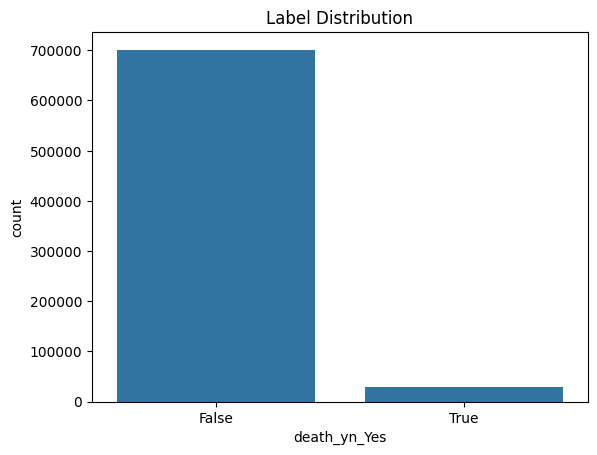

In [10]:
label_counts = df['death_yn_Yes'].value_counts()
print(label_counts)

label_proportions = label_counts / len(df)
print(label_proportions)

sns.countplot(x=df['death_yn_Yes'])
plt.title('Label Distribution')
plt.show()

In [11]:
#Proportion of each feature that is null.
df.isnull().sum()

current_status_Laboratory-confirmed case                                        0
current_status_Probable Case                                                    0
sex_Female                                                                      0
sex_Male                                                                        0
sex_Other                                                                       0
age_group_0 - 9 Years                                                           0
age_group_10 - 19 Years                                                         0
age_group_20 - 29 Years                                                         0
age_group_30 - 39 Years                                                         0
age_group_40 - 49 Years                                                         0
age_group_50 - 59 Years                                                         0
age_group_60 - 69 Years                                                         0
age_group_70 - 7

In [12]:
df.shape

(730187, 24)

In [13]:
features = df.drop('death_yn_Yes', axis = 1)
labels = df['death_yn_Yes']
features_tensor = torch.tensor(features.values, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

In [14]:
X = features_tensor.numpy()
y = labels_tensor.numpy()

In [15]:
#Initialize the Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=100, criterion = 'entropy', random_state=42)

#Fit the model on training data
rf_classifier.fit(X_train, y_train)

#Predict on validation data
y_pred_val = rf_classifier.predict(X_val)

#Predict on testing data
y_pred_test = rf_classifier.predict(X_test)

In [16]:
#Evaluate the model
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

print("Testing Accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_val, y_pred_test))

Validation Accuracy: 0.9666662101644777
              precision    recall  f1-score   support

         0.0       0.98      0.99      0.98     70220
         1.0       0.59      0.43      0.50      2799

    accuracy                           0.97     73019
   macro avg       0.78      0.71      0.74     73019
weighted avg       0.96      0.97      0.96     73019

Testing Accuracy: 0.9676796450238979
              precision    recall  f1-score   support

         0.0       0.96      0.97      0.97     70220
         1.0       0.04      0.03      0.04      2799

    accuracy                           0.94     73019
   macro avg       0.50      0.50      0.50     73019
weighted avg       0.93      0.94      0.93     73019



In [17]:
# Predict probabilities for the test and val set
y_scores_val = rf_classifier.predict_proba(X_val)[:, 1]
y_scores_test = rf_classifier.predict_proba(X_test)[:, 1]

In [18]:
#Function to plot ROC Curve
def plot_roc_curve(y_true, y_score, title):
    fpr, tpr, thresholds = roc_curve(y_true, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(title)
    plt.legend(loc="lower right")
    plt.show()

#Function to plot Precision-Recall Curve
def plot_precision_recall_curve(y_true, y_score, title):
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    average_precision = average_precision_score(y_true, y_score)

    plt.figure()
    plt.step(recall, precision, where='post', label='Precision-Recall curve (area = %0.2f)' % average_precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.ylim([0.0, 1.05])
    plt.xlim([0.0, 1.0])
    plt.title(title)
    plt.legend(loc="lower left")
    plt.show()

#Function to plot Confusion Matrix
def plot_confusion_matrix(y_true, y_pred):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot()
    plt.show()

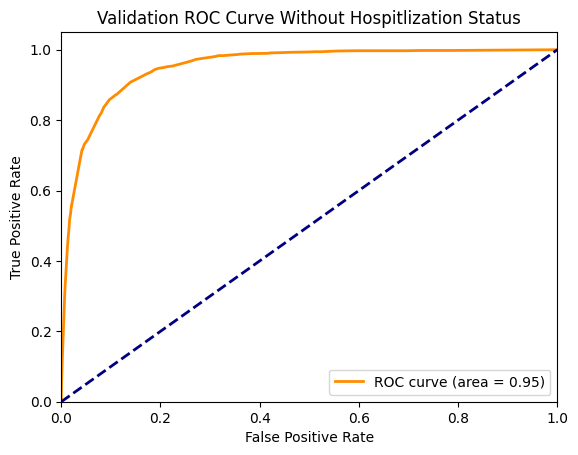

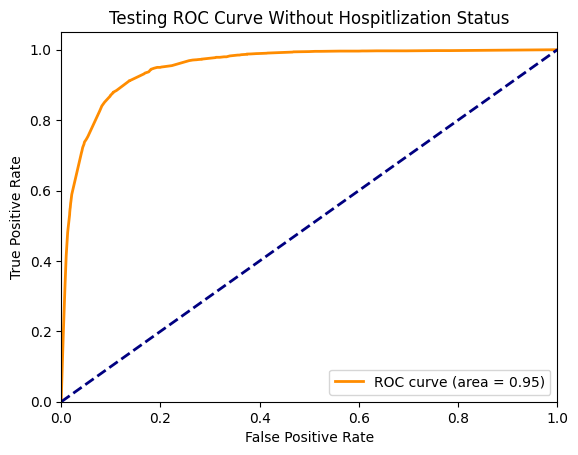

In [19]:
#Plot ROC Curve for validation set
plot_roc_curve(y_val, y_scores_val, "Validation ROC Curve Without Hospitlization Status")

#Plot ROC Curve for test set
plot_roc_curve(y_test, y_scores_test, "Testing ROC Curve Without Hospitlization Status")

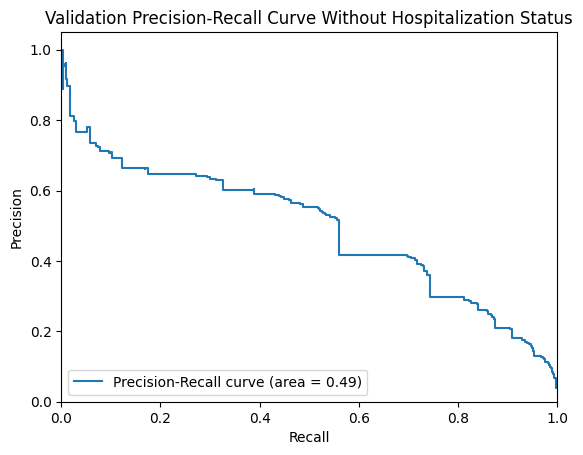

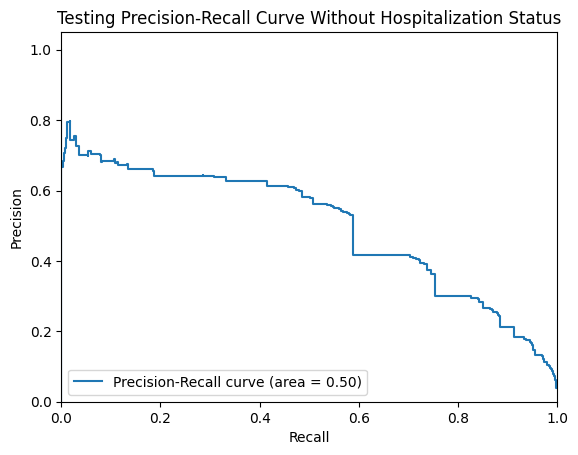

In [20]:
#Plot Precision-Recall Curve for validation set
plot_precision_recall_curve(y_val, y_scores_val, "Validation Precision-Recall Curve Without Hospitalization Status")

#Plot Precision-Recall Curve for test set
plot_precision_recall_curve(y_test, y_scores_test, "Testing Precision-Recall Curve Without Hospitalization Status")

Validation


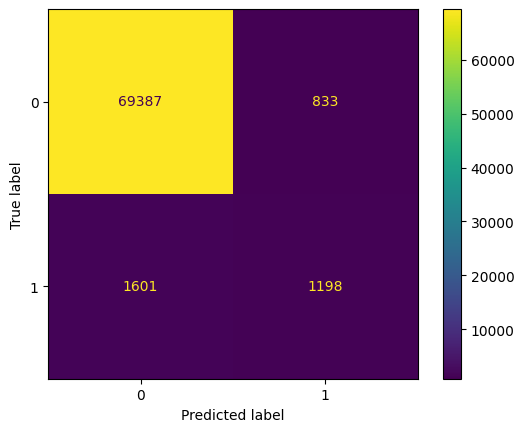

Testing


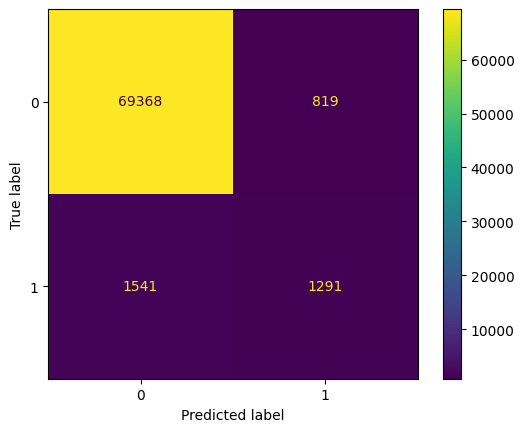

In [21]:
#Plot Confusion Matrix for validation set
print("Validation")
plot_confusion_matrix(y_val, y_pred_val)

#Plot Confusion Matrix for test set
print("Testing")
plot_confusion_matrix(y_test, y_pred_test)

In [22]:
feature_names = ['current_status_Laboratory-confirmed case', 'current_status_Probable Case','sex_Female',
                 'sex_Male', 'sex_Other', 'age_group_0 - 9 Years', 'age_group_10 - 19 Years', 'age_group_20 - 29 Years',
                 'age_group_30 - 39 Years', 'age_group_40 - 49 Years', 'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
                 'age_group_70 - 79 Years', 'age_group_80+ Years', 'race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic',
                 'race_ethnicity_combined_Asian, Non-Hispanic', 'race_ethnicity_combined_Black, Non-Hispanic', 'race_ethnicity_combined_Hispanic/Latino',
                 'race_ethnicity_combined_Multiple/Other, Non-Hispanic', 'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
                 'race_ethnicity_combined_White, Non-Hispanic', 'icu_yn_Yes', 'medcond_yn_Yes']

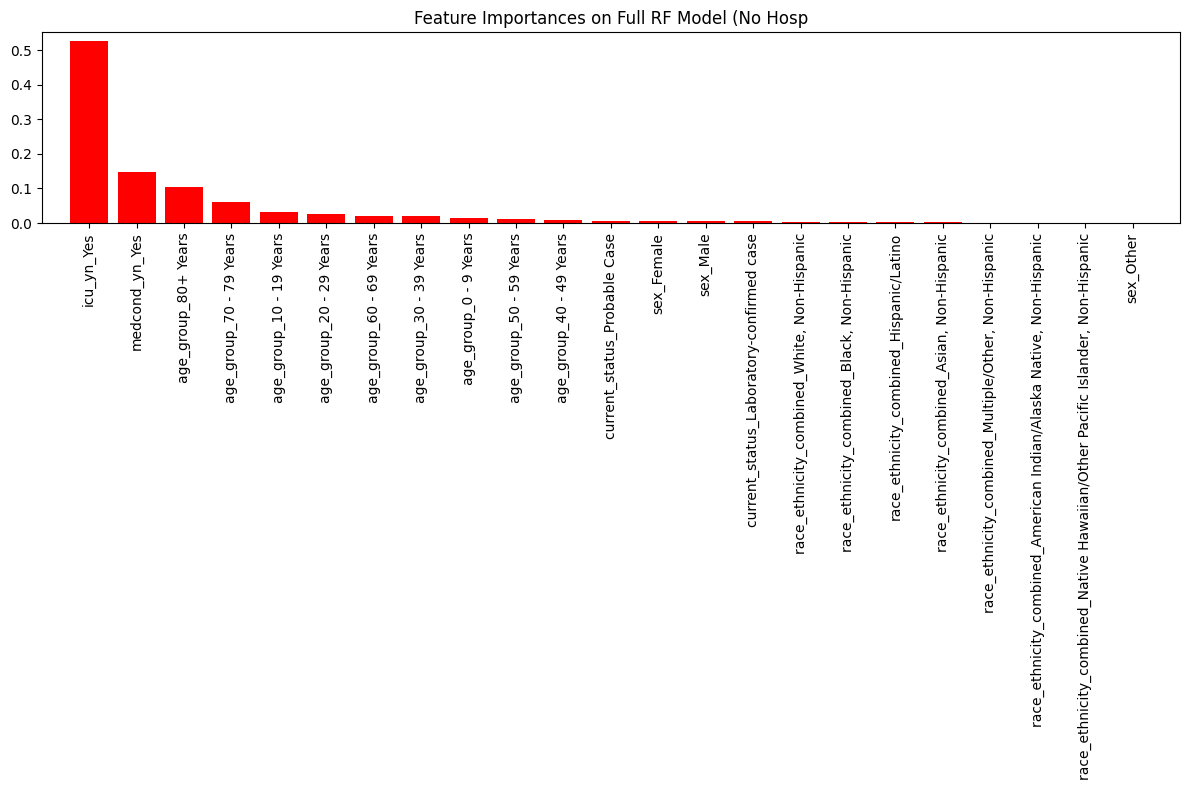

In [23]:
#Feature Importance Plot
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances on Full RF Model (No Hosp)")
plt.bar(range(len(importances)), importances[indices], color="r", align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.tight_layout()
plt.show()

In [24]:
start_time = time.time()
result = permutation_importance(
    rf_classifier, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 160.439 seconds


<ipython-input-25-a22c13a3baad>:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


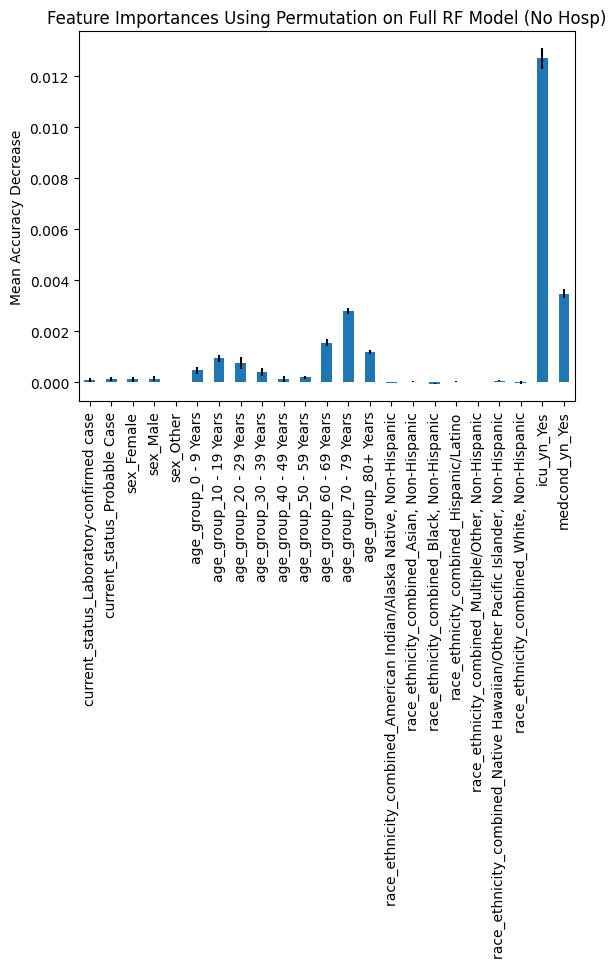

In [25]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature Importances Using Permutation on Full RF Model (No Hosp)")
ax.set_ylabel("Mean Accuracy Decrease")
fig.tight_layout()
plt.show()

In [26]:
explainer = shap.TreeExplainer(rf_classifier)
X_sample = shap.sample(X_train, 100)
shap_values_sample = explainer.shap_values(X_sample)

#Check shapes
print(f"SHAP values shape: {np.array(shap_values_sample).shape}")
print(f"X_train shape: {X_train.shape}")

shap_values_positive_class = shap_values_sample[:, :, 1]

SHAP values shape: (100, 23, 2)
X_train shape: (584149, 23)


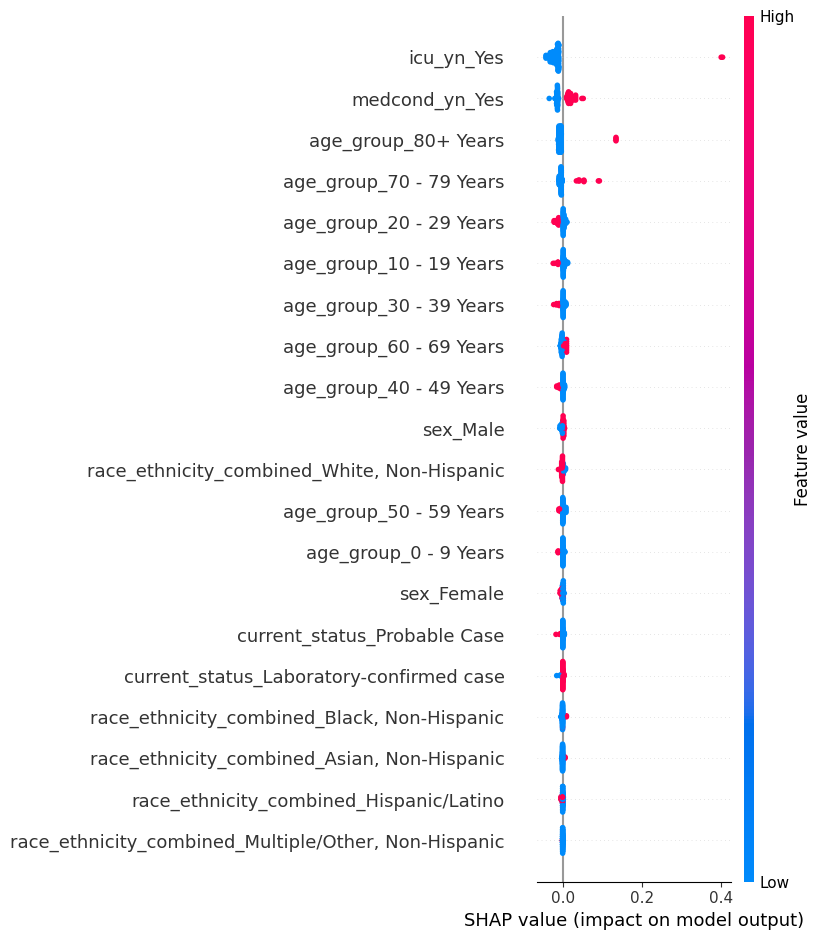

In [27]:
shap.summary_plot(shap_values_positive_class, X_sample, feature_names=feature_names, plot_type="dot")

### 2. Drop 'icu_yn_yes'

In [28]:
df = pd.read_pickle("/content/drive/MyDrive/Machine Learning Project/Code/cdcdata.pkl")
columns_to_encode = ['current_status', 'sex', 'age_group', 'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn']
df_encoded = one_hot_encoding_features(df, columns_to_encode)
cols_to_drop = ['cdc_case_earliest_dt', 'cdc_report_dt', 'pos_spec_dt', 'onset_dt', 'hosp_yn_No', 'icu_yn_No', 'death_yn_No', 'medcond_yn_No', 'icu_yn_Yes']
df_dropped = df_encoded.drop(cols_to_drop, axis=1)
df = df_dropped

In [29]:
features = df.drop('death_yn_Yes', axis=1)
labels = df['death_yn_Yes']
features_tensor = torch.tensor(features.values, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

In [30]:
X = features_tensor.numpy()
y = labels_tensor.numpy()

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)  # making the split 8:1:1

In [31]:
# Initialize the Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=100, criterion = 'entropy', random_state=42)

# Fit the model on training data
rf_classifier.fit(X_train, y_train)

# Predict on validation data
y_pred_val = rf_classifier.predict(X_val)

# Predict on testing data
y_pred_test = rf_classifier.predict(X_test)

In [32]:
# Evaluate the model
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

print("Testing Accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_val, y_pred_test))

Validation Accuracy: 0.9619551075747408
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     70220
         1.0       0.59      0.02      0.05      2799

    accuracy                           0.96     73019
   macro avg       0.78      0.51      0.51     73019
weighted avg       0.95      0.96      0.94     73019

Testing Accuracy: 0.9614483901450307
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     70220
         1.0       0.03      0.00      0.00      2799

    accuracy                           0.96     73019
   macro avg       0.49      0.50      0.49     73019
weighted avg       0.93      0.96      0.94     73019



In [33]:
# Predict probabilities for the test and val set
y_scores_val = rf_classifier.predict_proba(X_val)[:, 1]
y_scores_test = rf_classifier.predict_proba(X_test)[:, 1]

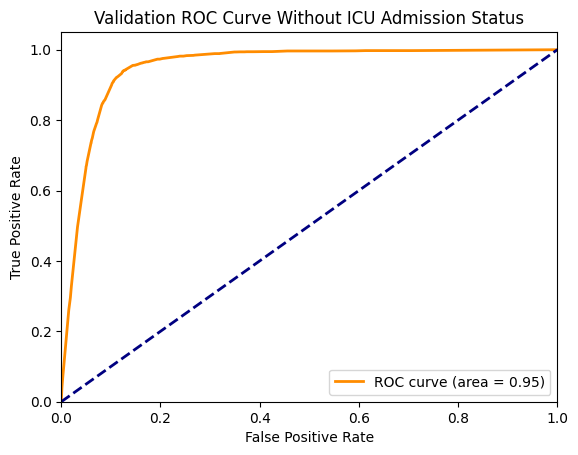

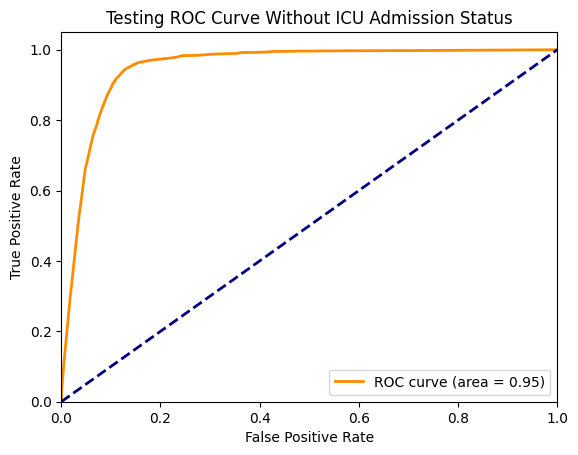

In [34]:
#Plot ROC Curve for validation set
plot_roc_curve(y_val, y_scores_val, "Validation ROC Curve Without ICU Admission Status")

#Plot ROC Curve for test set
plot_roc_curve(y_test, y_scores_test, "Testing ROC Curve Without ICU Admission Status")

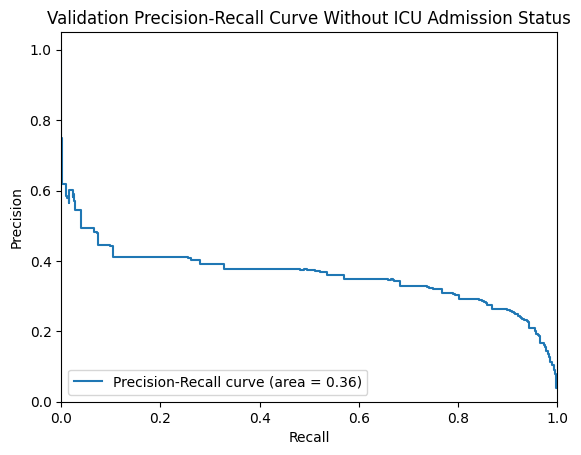

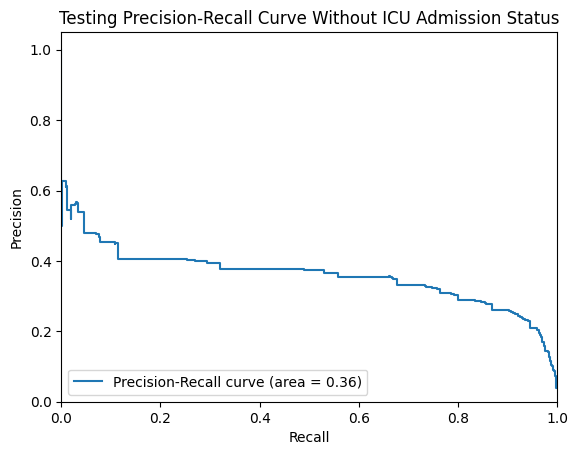

In [35]:
#Plot Precision-Recall Curve for validation set
plot_precision_recall_curve(y_val, y_scores_val, "Validation Precision-Recall Curve Without ICU Admission Status")

#Plot Precision-Recall Curve for test set
plot_precision_recall_curve(y_test, y_scores_test, "Testing Precision-Recall Curve Without ICU Admission Status")

Validation


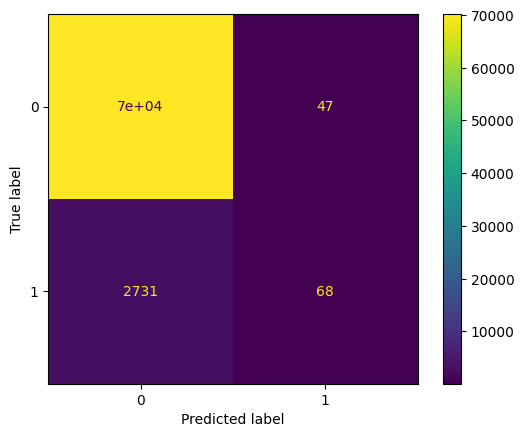

Testing


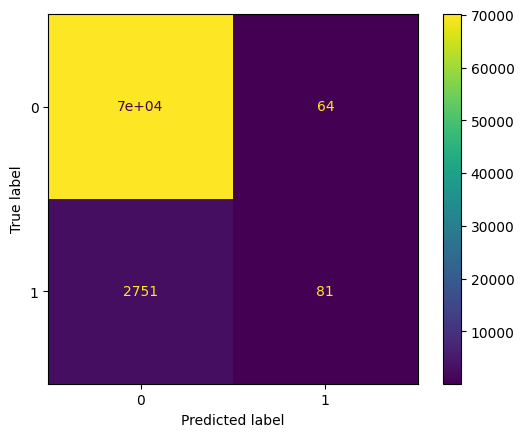

In [36]:
#Plot Confusion Matrix for validation set
print("Validation")
plot_confusion_matrix(y_val, y_pred_val)

#Plot Confusion Matrix for test set
print("Testing")
plot_confusion_matrix(y_test, y_pred_test)

In [37]:
feature_names = ['current_status_Laboratory-confirmed case', 'current_status_Probable Case','sex_Female',
                 'sex_Male', 'sex_Other', 'age_group_0 - 9 Years', 'age_group_10 - 19 Years', 'age_group_20 - 29 Years',
                 'age_group_30 - 39 Years', 'age_group_40 - 49 Years', 'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
                 'age_group_70 - 79 Years', 'age_group_80+ Years', 'race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic',
                 'race_ethnicity_combined_Asian, Non-Hispanic', 'race_ethnicity_combined_Black, Non-Hispanic', 'race_ethnicity_combined_Hispanic/Latino',
                 'race_ethnicity_combined_Multiple/Other, Non-Hispanic', 'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
                 'race_ethnicity_combined_White, Non-Hispanic', 'hosp_yn_Yes', 'medcond_yn_Yes']

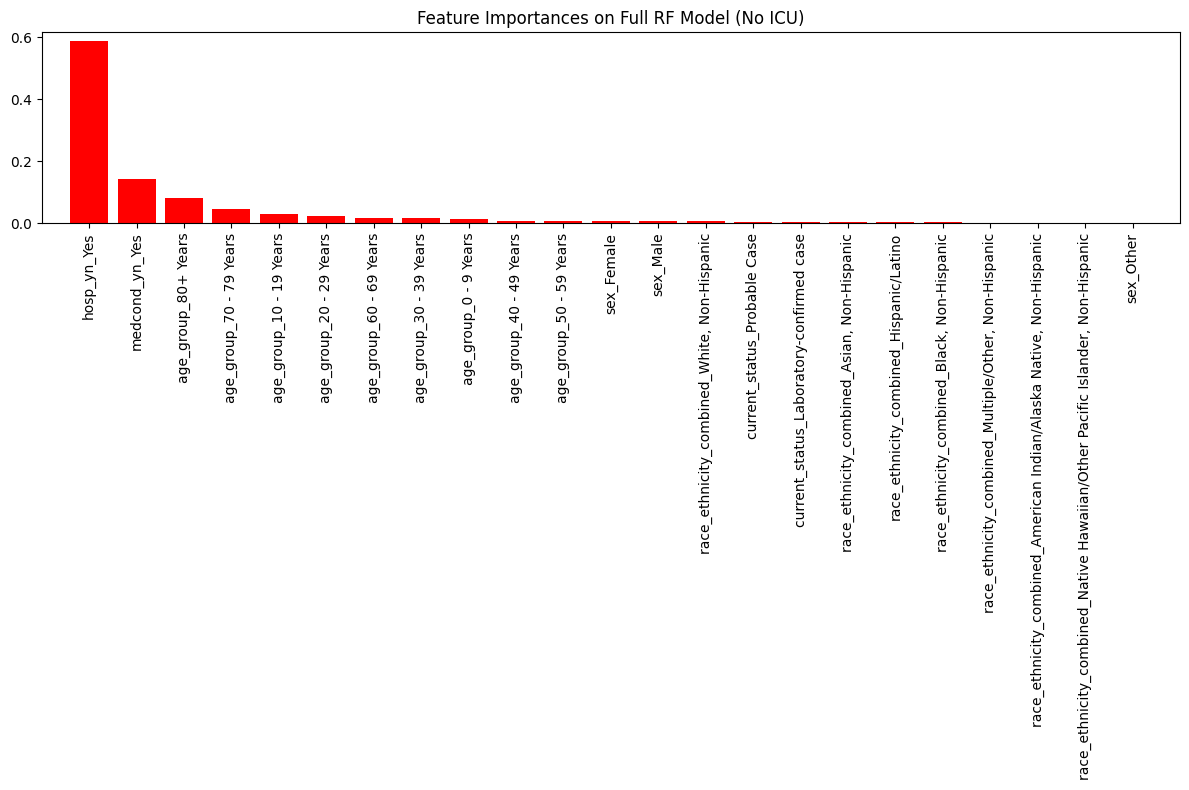

In [38]:
#Feature Importance Plot
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances on Full RF Model (No ICU)")
plt.bar(range(len(importances)), importances[indices], color="r", align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.tight_layout()
plt.show()

In [39]:
start_time = time.time()
result = permutation_importance(
    rf_classifier, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 137.129 seconds


<ipython-input-40-7ae1a2261f7e>:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


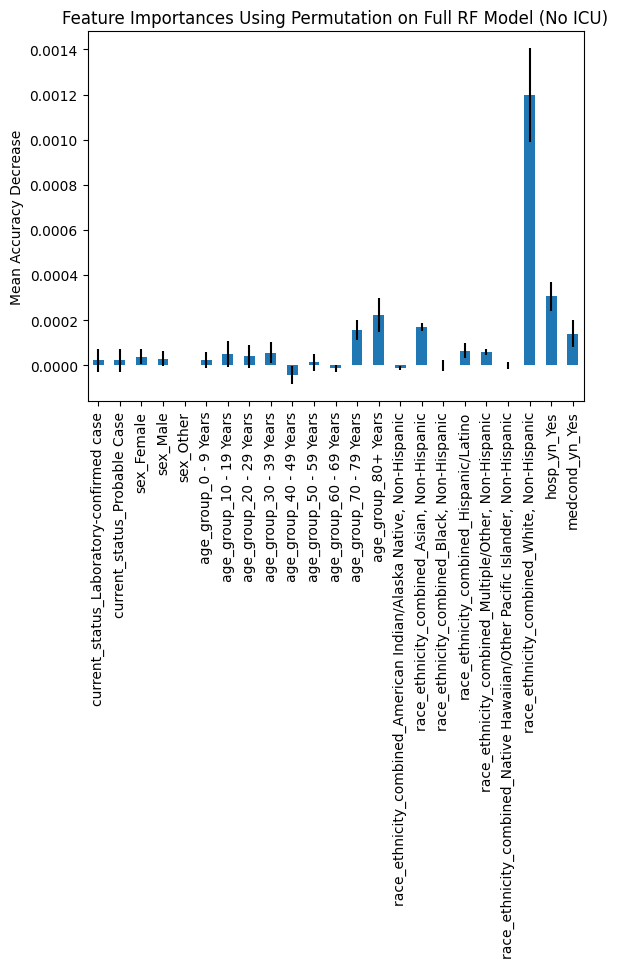

In [40]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature Importances Using Permutation on Full RF Model (No ICU)")
ax.set_ylabel("Mean Accuracy Decrease")
fig.tight_layout()
plt.show()

In [41]:
explainer = shap.TreeExplainer(rf_classifier)

X_sample = shap.sample(X_train, 100)
shap_values_sample = explainer.shap_values(X_sample)

#Check shapes
print(f"SHAP values shape: {np.array(shap_values_sample).shape}")
print(f"X_train shape: {X_train.shape}")

shap_values_positive_class = shap_values_sample[:, :, 1]

SHAP values shape: (100, 23, 2)
X_train shape: (584149, 23)


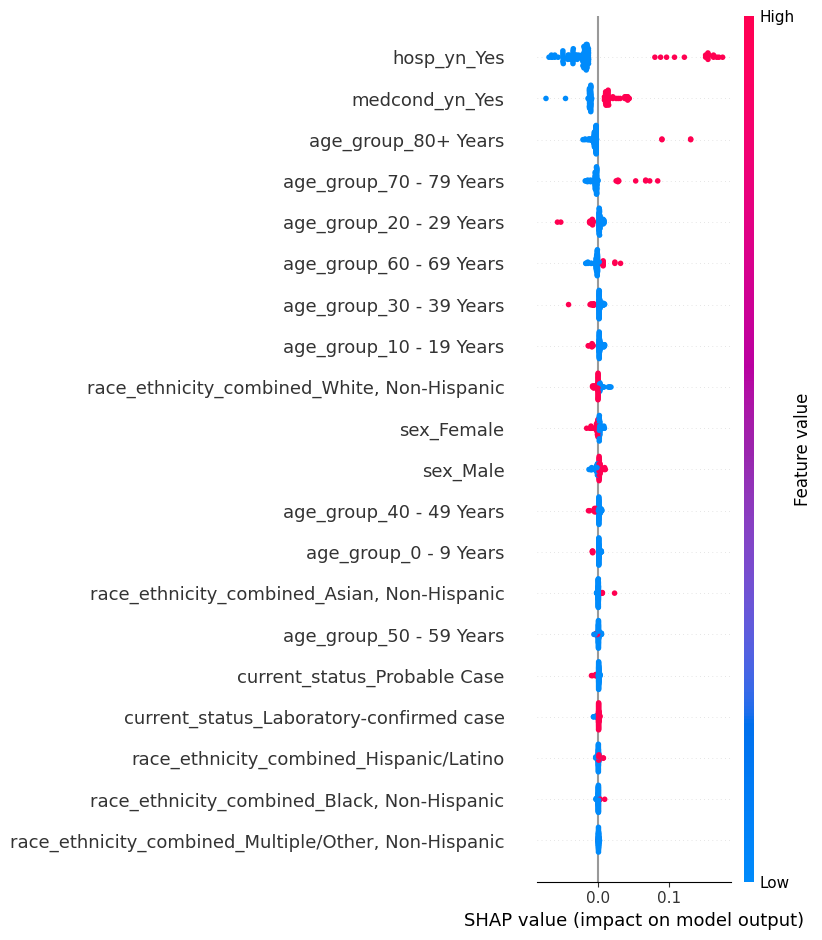

In [42]:
shap.summary_plot(shap_values_positive_class, X_sample, feature_names=feature_names, plot_type="dot")

### 3. Drop both 'icu_yn_Yes' and 'hosp_yn_Yes'

In [43]:
df = pd.read_pickle("/content/drive/MyDrive/Machine Learning Project/Code/cdcdata.pkl")
columns_to_encode = ['current_status', 'sex', 'age_group', 'race_ethnicity_combined', 'hosp_yn', 'icu_yn', 'death_yn', 'medcond_yn']
df_encoded = one_hot_encoding_features(df, columns_to_encode)
cols_to_drop = ['cdc_case_earliest_dt', 'cdc_report_dt', 'pos_spec_dt', 'onset_dt', 'hosp_yn_No', 'icu_yn_No', 'death_yn_No', 'medcond_yn_No', 'hosp_yn_Yes', 'icu_yn_Yes']
df_dropped = df_encoded.drop(cols_to_drop, axis=1)
df = df_dropped

In [44]:
features = df.drop('death_yn_Yes', axis=1)
labels = df['death_yn_Yes']
features_tensor = torch.tensor(features.values, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

In [45]:
X = features_tensor.numpy()
y = labels_tensor.numpy()

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)  # making the split 8:1:1

In [46]:
#Initialize the Random Forest model
rf_classifier = RandomForestClassifier(n_estimators=100, criterion = 'entropy', random_state=42)

#Fit the model on training data
rf_classifier.fit(X_train, y_train)

#Predict on validation data
y_pred_val = rf_classifier.predict(X_val)

#Predict on testing data
y_pred_test = rf_classifier.predict(X_test)

In [47]:
#Evaluate the model
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

print("Testing Accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_val, y_pred_test))

Validation Accuracy: 0.961763376655391
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     70220
         1.0       0.56      0.01      0.02      2799

    accuracy                           0.96     73019
   macro avg       0.76      0.51      0.50     73019
weighted avg       0.95      0.96      0.94     73019

Testing Accuracy: 0.9612703542913488
              precision    recall  f1-score   support

         0.0       0.96      1.00      0.98     70220
         1.0       0.02      0.00      0.00      2799

    accuracy                           0.96     73019
   macro avg       0.49      0.50      0.49     73019
weighted avg       0.93      0.96      0.94     73019



In [48]:
#Predict probabilities for the test and val set
y_scores_val = rf_classifier.predict_proba(X_val)[:, 1]
y_scores_test = rf_classifier.predict_proba(X_test)[:, 1]

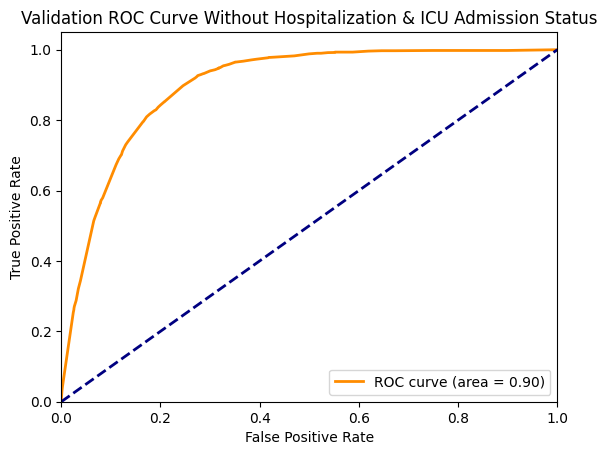

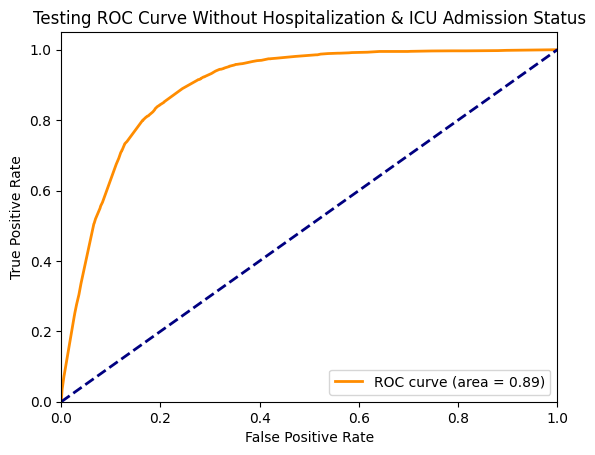

In [49]:
#Plot ROC Curve for validation set
plot_roc_curve(y_val, y_scores_val, "Validation ROC Curve Without Hospitalization & ICU Admission Status")

#Plot ROC Curve for test set
plot_roc_curve(y_test, y_scores_test, "Testing ROC Curve Without Hospitalization & ICU Admission Status")

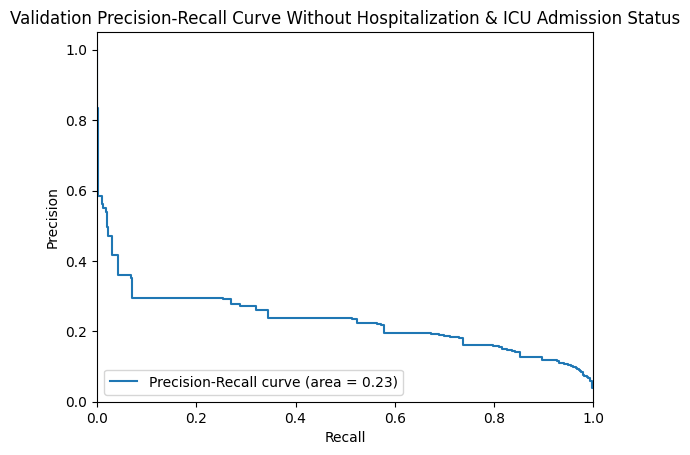

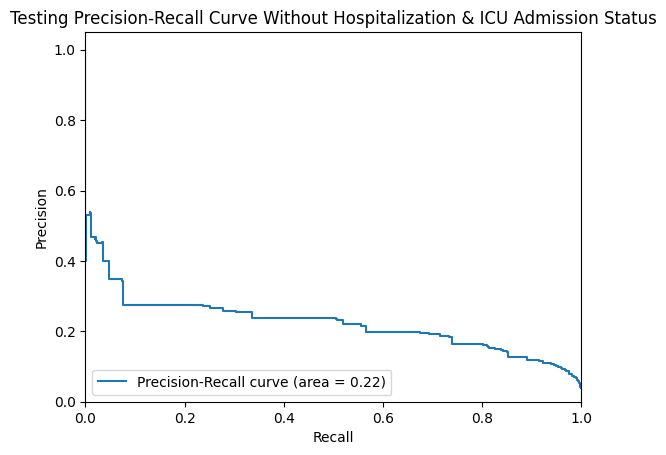

In [50]:
#Plot Precision-Recall Curve for validation set
plot_precision_recall_curve(y_val, y_scores_val, "Validation Precision-Recall Curve Without Hospitalization & ICU Admission Status")

#Plot Precision-Recall Curve for test set
plot_precision_recall_curve(y_test, y_scores_test, "Testing Precision-Recall Curve Without Hospitalization & ICU Admission Status")

Validation


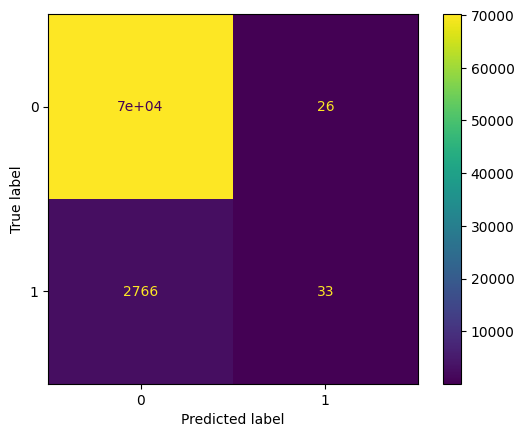

Testing


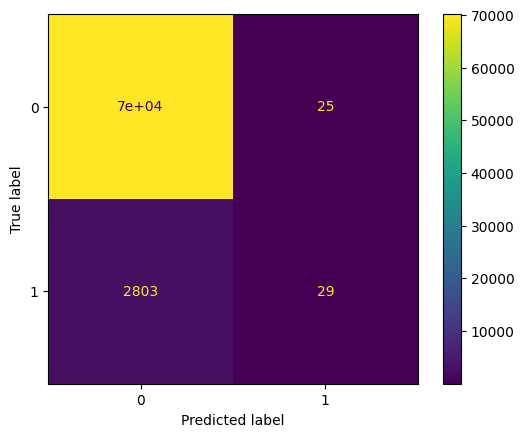

In [51]:
#Plot Confusion Matrix for validation set
print("Validation")
plot_confusion_matrix(y_val, y_pred_val)

#Plot Confusion Matrix for test set
print("Testing")
plot_confusion_matrix(y_test, y_pred_test)

In [52]:
feature_names = ['current_status_Laboratory-confirmed case', 'current_status_Probable Case','sex_Female',
                 'sex_Male', 'sex_Other', 'age_group_0 - 9 Years', 'age_group_10 - 19 Years', 'age_group_20 - 29 Years',
                 'age_group_30 - 39 Years', 'age_group_40 - 49 Years', 'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
                 'age_group_70 - 79 Years', 'age_group_80+ Years', 'race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic',
                 'race_ethnicity_combined_Asian, Non-Hispanic', 'race_ethnicity_combined_Black, Non-Hispanic', 'race_ethnicity_combined_Hispanic/Latino',
                 'race_ethnicity_combined_Multiple/Other, Non-Hispanic', 'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
                 'race_ethnicity_combined_White, Non-Hispanic', 'medcond_yn_Yes']

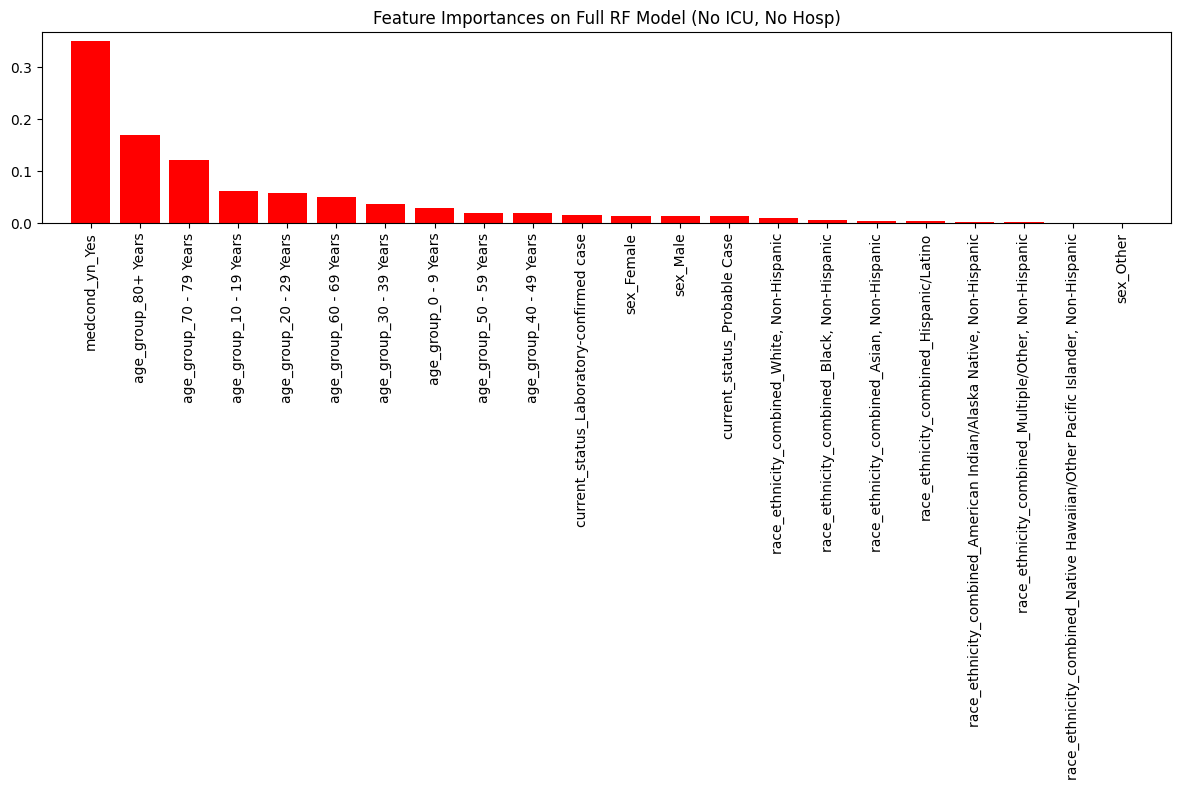

In [53]:
#Feature Importance Plot
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances on Full RF Model (No ICU, No Hosp)")
plt.bar(range(len(importances)), importances[indices], color="r", align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.tight_layout()
plt.show()

In [54]:
start_time = time.time()
result = permutation_importance(
    rf_classifier, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 119.941 seconds


<ipython-input-55-357e762ed8c3>:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


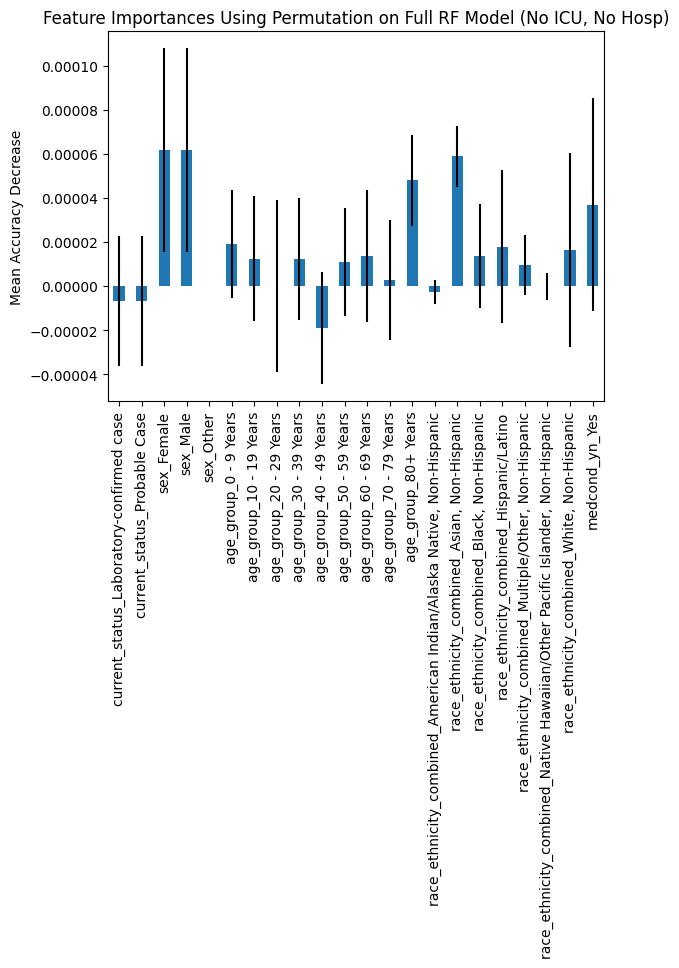

In [55]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature Importances Using Permutation on Full RF Model (No ICU, No Hosp)")
ax.set_ylabel("Mean Accuracy Decrease")
fig.tight_layout()
plt.show()

In [56]:
explainer = shap.TreeExplainer(rf_classifier)

X_sample = shap.sample(X_train, 100)
shap_values_sample = explainer.shap_values(X_sample)

#Check shapes
print(f"SHAP values shape: {np.array(shap_values_sample).shape}")
print(f"X_train shape: {X_train.shape}")

shap_values_positive_class = shap_values_sample[:, :, 1]

SHAP values shape: (100, 22, 2)
X_train shape: (584149, 22)


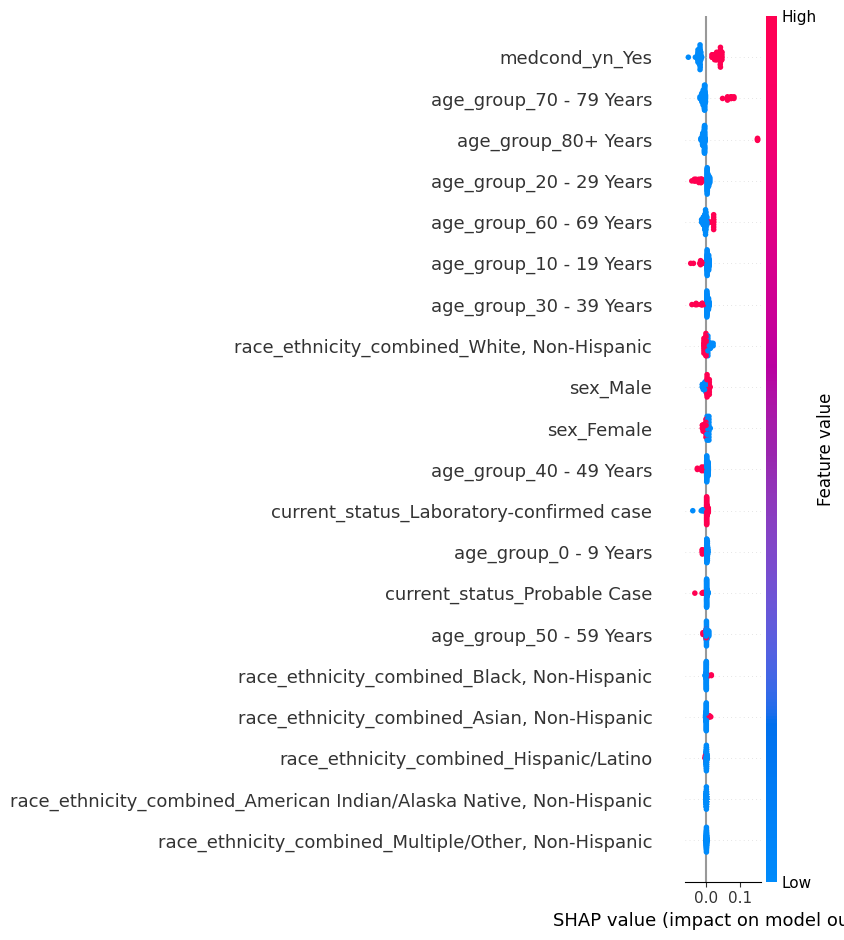

In [57]:
shap.summary_plot(shap_values_positive_class, X_sample, feature_names=feature_names, plot_type="dot")

### 4. Fixing data imbalance

In [58]:
#Majority class
false_data = df[df['death_yn_Yes'] == 0]
#Minority class
true_data = df[df['death_yn_Yes'] == 1]

undersampled_false_data = false_data.sample(n=len(true_data), random_state=42)
balanced_df = pd.concat([undersampled_false_data, true_data], ignore_index=True)
balanced_df = shuffle(balanced_df, random_state=42)

In [59]:
features = balanced_df.drop('death_yn_Yes', axis=1)
labels = balanced_df['death_yn_Yes']
features_tensor = torch.tensor(features.values, dtype=torch.float32)
labels_tensor = torch.tensor(labels.values, dtype=torch.float32)

In [60]:
X = features_tensor.numpy()
y = labels_tensor.numpy()

X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)  # making the split 8:1:1

In [61]:
#Initialize the RF model
rf_classifier = RandomForestClassifier(n_estimators=100, criterion = 'entropy', random_state=42)

#Fit the model on training data
rf_classifier.fit(X_train, y_train)

#Predict on validation data
y_pred_val = rf_classifier.predict(X_val)

#Predict on testing data
y_pred_test = rf_classifier.predict(X_test)

In [62]:
#Evaluate the model
print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print(classification_report(y_val, y_pred_val))

print("Testing Accuracy:", accuracy_score(y_test, y_pred_test))
print(classification_report(y_val, y_pred_test))

Validation Accuracy: 0.8179923584577978
              precision    recall  f1-score   support

         0.0       0.87      0.75      0.80      2880
         1.0       0.78      0.89      0.83      2878

    accuracy                           0.82      5758
   macro avg       0.82      0.82      0.82      5758
weighted avg       0.82      0.82      0.82      5758

Testing Accuracy: 0.8176450156304272
              precision    recall  f1-score   support

         0.0       0.50      0.43      0.46      2880
         1.0       0.50      0.57      0.53      2878

    accuracy                           0.50      5758
   macro avg       0.50      0.50      0.50      5758
weighted avg       0.50      0.50      0.50      5758



In [63]:
#Predict probabilities for the test and val set
y_scores_val = rf_classifier.predict_proba(X_val)[:, 1]
y_scores_test = rf_classifier.predict_proba(X_test)[:, 1]

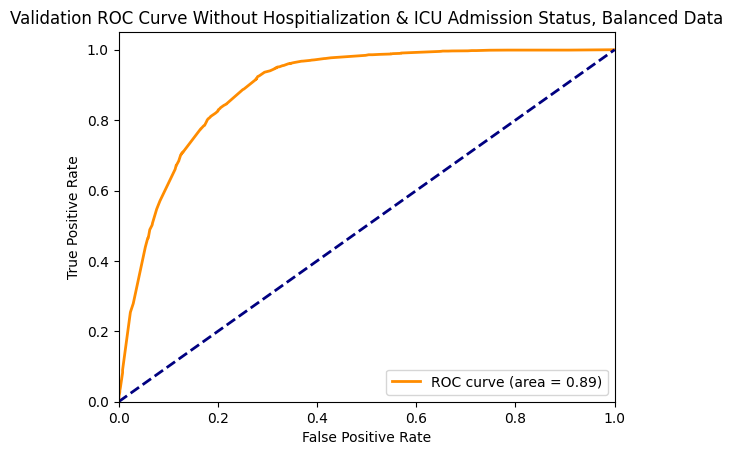

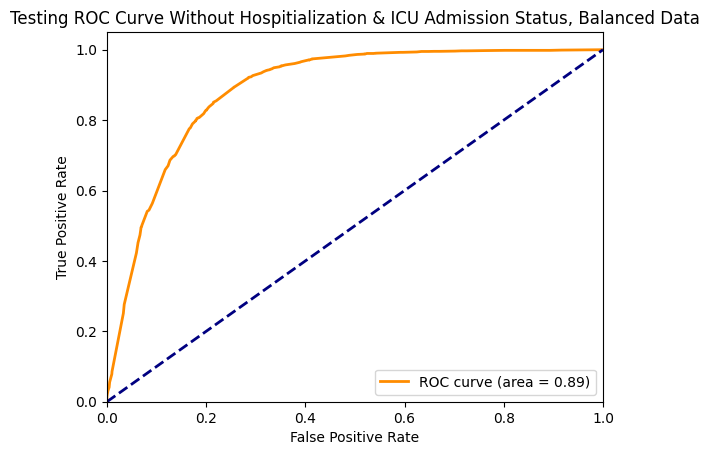

In [64]:
#Plot ROC Curve for validation set
plot_roc_curve(y_val, y_scores_val, "Validation ROC Curve Without Hospitialization & ICU Admission Status, Balanced Data")

#Plot ROC Curve for test set
plot_roc_curve(y_test, y_scores_test, "Testing ROC Curve Without Hospitialization & ICU Admission Status, Balanced Data")

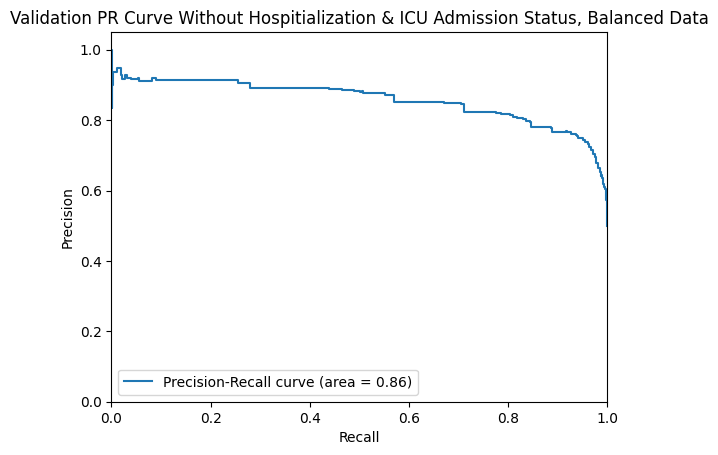

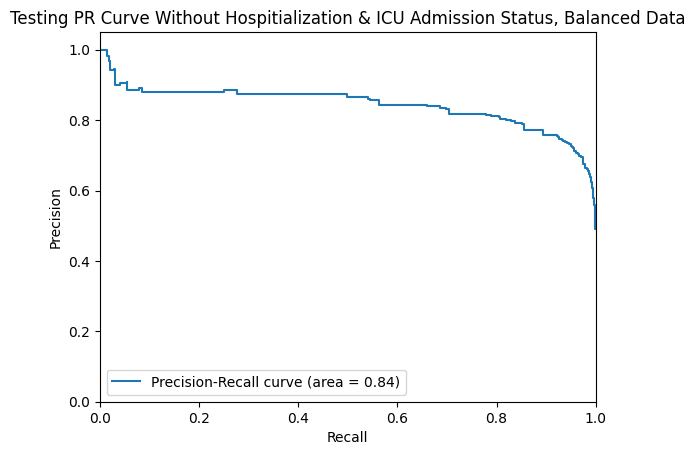

In [65]:
#Plot Precision-Recall Curve for validation set
plot_precision_recall_curve(y_val, y_scores_val, "Validation PR Curve Without Hospitialization & ICU Admission Status, Balanced Data")

#Plot Precision-Recall Curve for test set
plot_precision_recall_curve(y_test, y_scores_test, "Testing PR Curve Without Hospitialization & ICU Admission Status, Balanced Data")

Validation


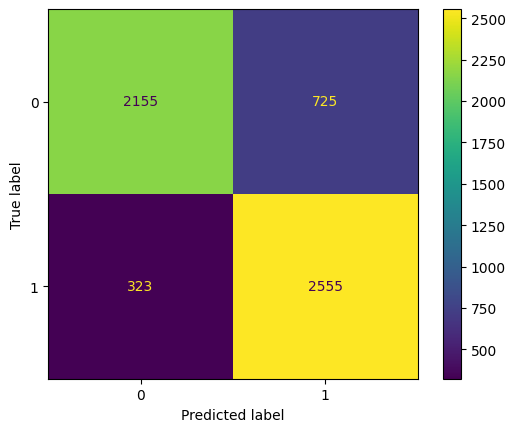

Testing


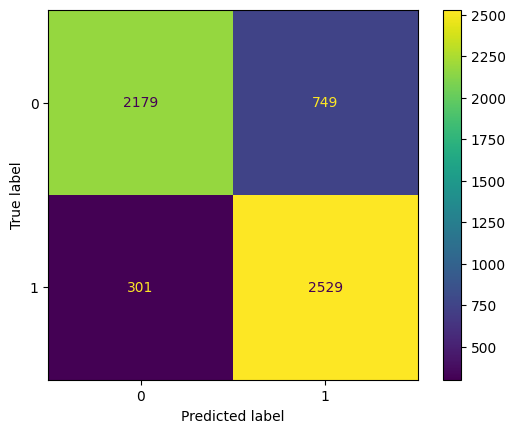

In [66]:
#Plot Confusion Matrix for validation set
print("Validation")
plot_confusion_matrix(y_val, y_pred_val)

#Plot Confusion Matrix for test set
print("Testing")
plot_confusion_matrix(y_test, y_pred_test)

In [67]:
feature_names = ['current_status_Laboratory-confirmed case', 'current_status_Probable Case','sex_Female',
                 'sex_Male', 'sex_Other', 'age_group_0 - 9 Years', 'age_group_10 - 19 Years', 'age_group_20 - 29 Years',
                 'age_group_30 - 39 Years', 'age_group_40 - 49 Years', 'age_group_50 - 59 Years', 'age_group_60 - 69 Years',
                 'age_group_70 - 79 Years', 'age_group_80+ Years', 'race_ethnicity_combined_American Indian/Alaska Native, Non-Hispanic',
                 'race_ethnicity_combined_Asian, Non-Hispanic', 'race_ethnicity_combined_Black, Non-Hispanic', 'race_ethnicity_combined_Hispanic/Latino',
                 'race_ethnicity_combined_Multiple/Other, Non-Hispanic', 'race_ethnicity_combined_Native Hawaiian/Other Pacific Islander, Non-Hispanic',
                 'race_ethnicity_combined_White, Non-Hispanic', 'medcond_yn_Yes']

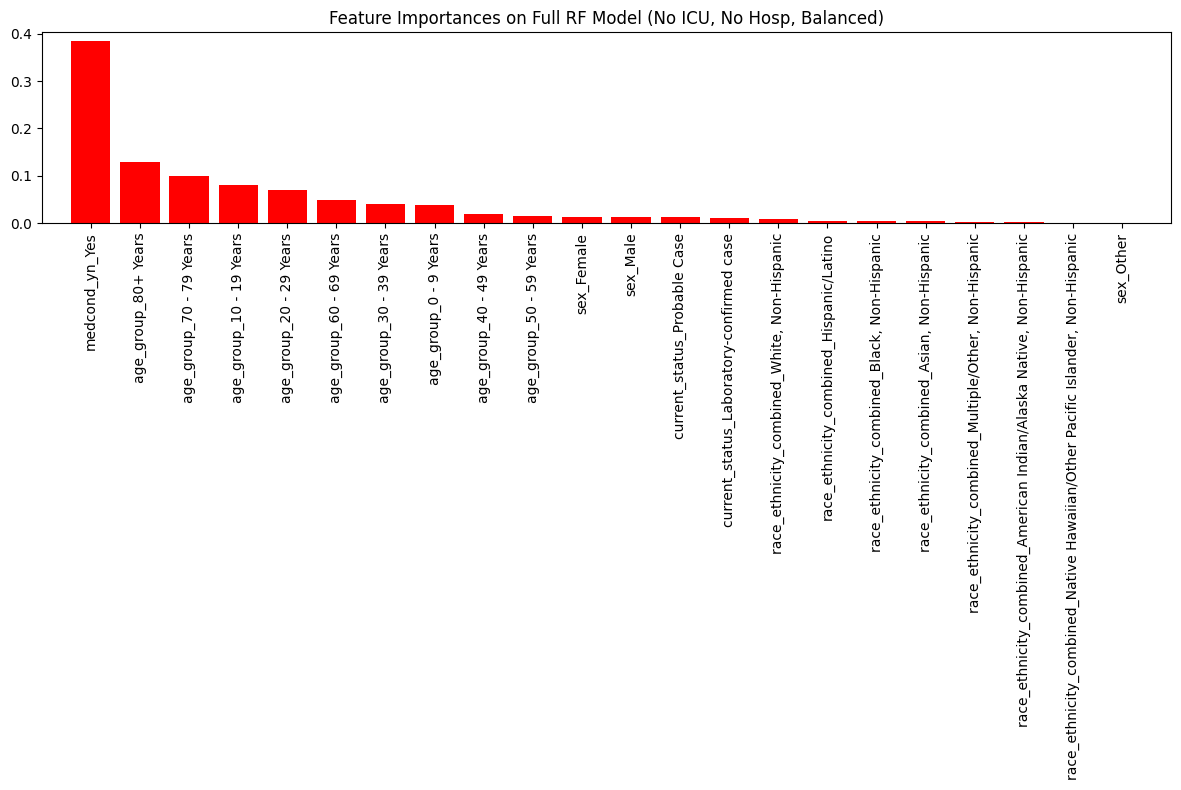

In [68]:
#Feature Importance Plot
importances = rf_classifier.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances on Full RF Model (No ICU, No Hosp, Balanced)")
plt.bar(range(len(importances)), importances[indices], color="r", align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.tight_layout()
plt.show()

In [69]:
start_time = time.time()
result = permutation_importance(
    rf_classifier, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 12.612 seconds


<ipython-input-70-e124643c0882>:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


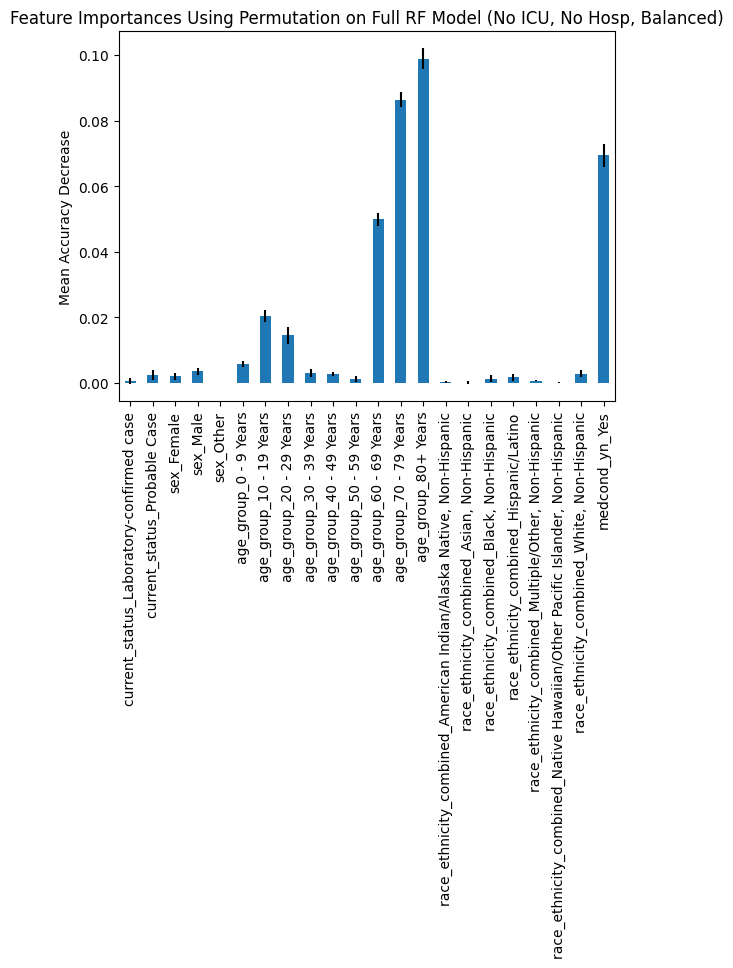

In [70]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature Importances Using Permutation on Full RF Model (No ICU, No Hosp, Balanced)")
ax.set_ylabel("Mean Accuracy Decrease")
fig.tight_layout()
plt.show()

In [71]:
explainer = shap.TreeExplainer(rf_classifier)

X_sample = shap.sample(X_train, 10000)
shap_values_sample = explainer.shap_values(X_sample)

#Check shapes
print(f"SHAP values shape: {np.array(shap_values_sample).shape}")
print(f"X_train shape: {X_train.shape}")

shap_values_positive_class = shap_values_sample[:, :, 1]

SHAP values shape: (10000, 22, 2)
X_train shape: (46056, 22)


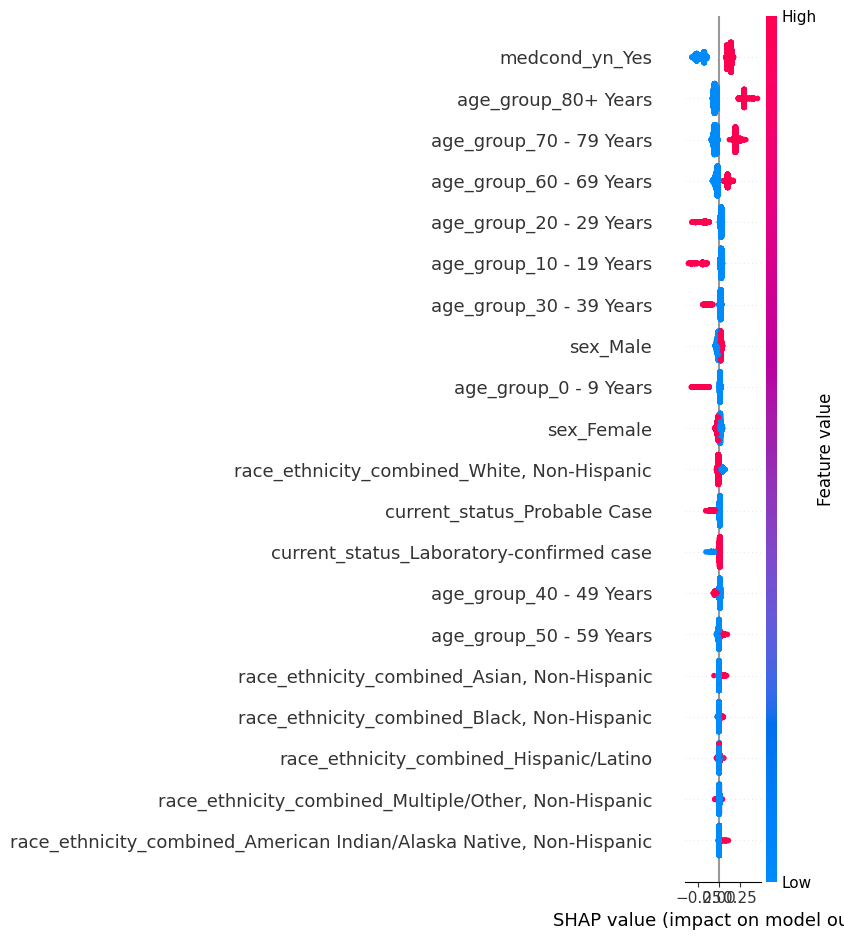

In [72]:
shap.summary_plot(shap_values_positive_class, X_sample, feature_names=feature_names, plot_type="dot")

### Model Tuning

Now that we have an improved model and balanced dataset, we will play around with hyperparamters to determine the best RF model.

In [73]:
#Define hyperparameters and their respective ranges to consider for the random search
param_distributions = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [10, 20, 30, 40, 50, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False],
    'class_weight': ['balanced', 'balanced_subsample']}

#Initialize the base model
rf_classifier = RandomForestClassifier(random_state=42)

#Initialize RandomizedSearchCV with the desired number of iterations and cross-validation folds
random_search = RandomizedSearchCV(
    estimator=rf_classifier,
    param_distributions=param_distributions,
    n_iter=100,
    cv=3,
    verbose=2,
    random_state=42,
    n_jobs=-1,
    scoring='f1_weighted'
)

#Perform the RandomizedSearchCV to find the best model
best_rf = random_search.fit(X_train, y_train)

#Best hyperparameters from RandomizedSearchCV
print("Best hyperparameters:\n", best_rf.best_params_)

Fitting 3 folds for each of 100 candidates, totalling 300 fits
Best hyperparameters:
 {'n_estimators': 100, 'min_samples_split': 10, 'min_samples_leaf': 2, 'max_depth': 20, 'class_weight': 'balanced', 'bootstrap': True}


In [74]:
#Evaluate the best model on the validation set
best_rf_model = best_rf.best_estimator_
y_pred_val = best_rf_model.predict(X_val)
y_pred_test = best_rf_model.predict(X_test)

print("Validation Accuracy:", accuracy_score(y_val, y_pred_val))
print("Validation Classification Report:")
print(classification_report(y_val, y_pred_val))

print("Testing Accuracy:", accuracy_score(y_test, y_pred_test))
print("Testing Classification Report:")
print(classification_report(y_test, y_pred_test))

Validation Accuracy: 0.8179923584577978
Validation Classification Report:
              precision    recall  f1-score   support

         0.0       0.87      0.75      0.80      2880
         1.0       0.78      0.89      0.83      2878

    accuracy                           0.82      5758
   macro avg       0.82      0.82      0.82      5758
weighted avg       0.82      0.82      0.82      5758

Testing Accuracy: 0.8178186870441125
Testing Classification Report:
              precision    recall  f1-score   support

         0.0       0.88      0.74      0.81      2928
         1.0       0.77      0.89      0.83      2830

    accuracy                           0.82      5758
   macro avg       0.83      0.82      0.82      5758
weighted avg       0.83      0.82      0.82      5758



In [75]:
#Predict probabilities for the test and val set
y_scores_val = best_rf_model.predict_proba(X_val)[:, 1]
y_scores_test = best_rf_model.predict_proba(X_test)[:, 1]

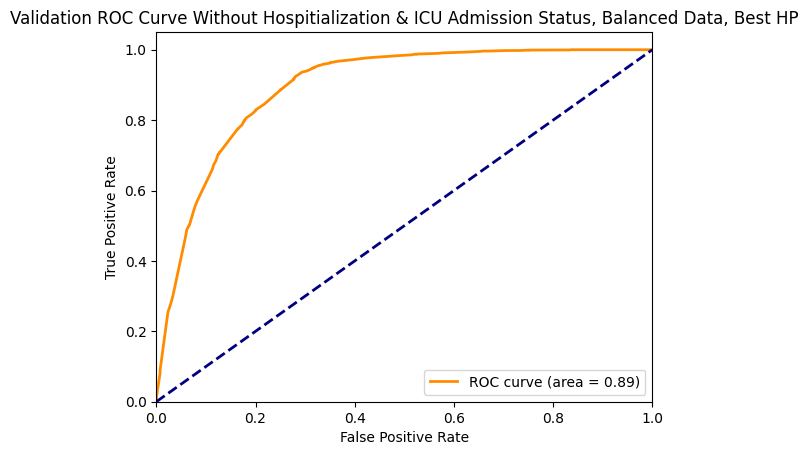

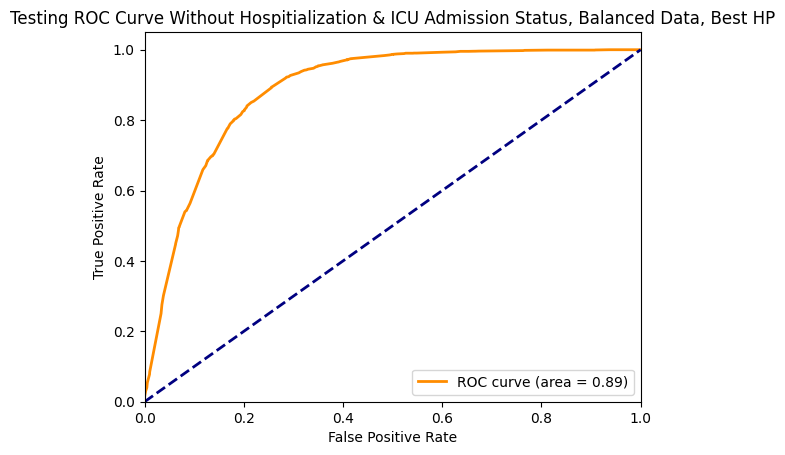

In [76]:
#Plot ROC Curve for validation set
plot_roc_curve(y_val, y_scores_val, "Validation ROC Curve Without Hospitialization & ICU Admission Status, Balanced Data, Best HP")

#Plot ROC Curve for test set
plot_roc_curve(y_test, y_scores_test, "Testing ROC Curve Without Hospitialization & ICU Admission Status, Balanced Data, Best HP")

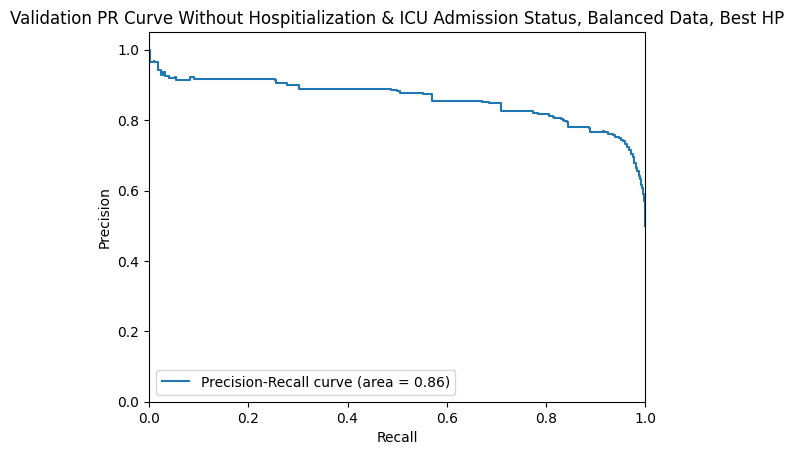

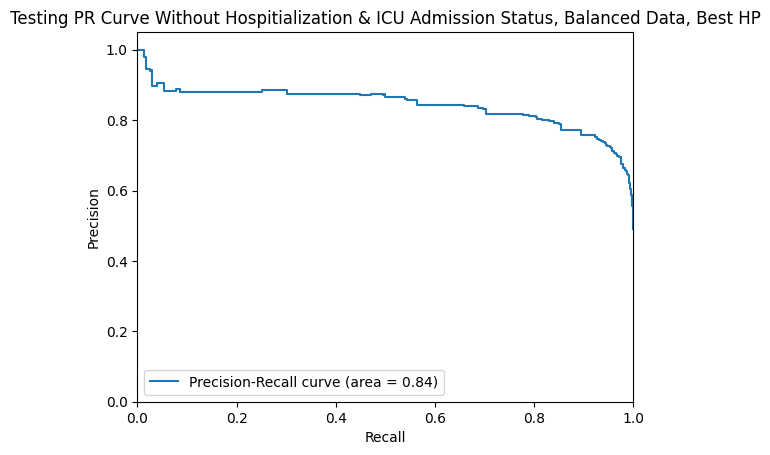

In [77]:
#Plot Precision-Recall Curve for validation set
plot_precision_recall_curve(y_val, y_scores_val, "Validation PR Curve Without Hospitialization & ICU Admission Status, Balanced Data, Best HP")

#Plot Precision-Recall Curve for test set
plot_precision_recall_curve(y_test, y_scores_test, "Testing PR Curve Without Hospitialization & ICU Admission Status, Balanced Data, Best HP")

Validation


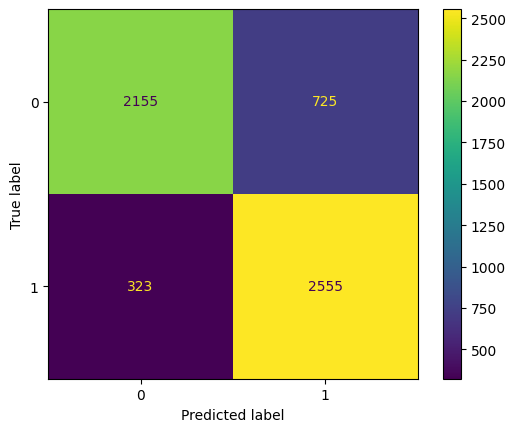

Testing


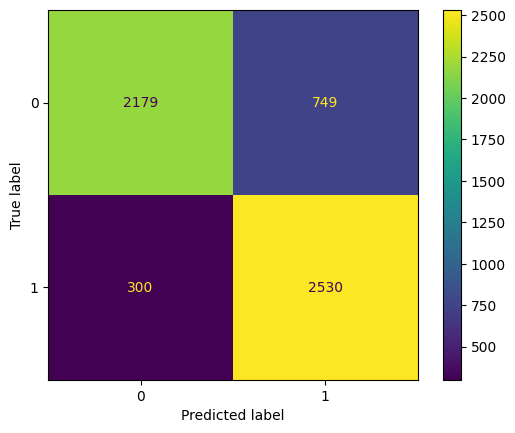

In [78]:
#Plot Confusion Matrix for validation set
print("Validation")
plot_confusion_matrix(y_val, y_pred_val)

#Plot Confusion Matrix for test set
print("Testing")
plot_confusion_matrix(y_test, y_pred_test)

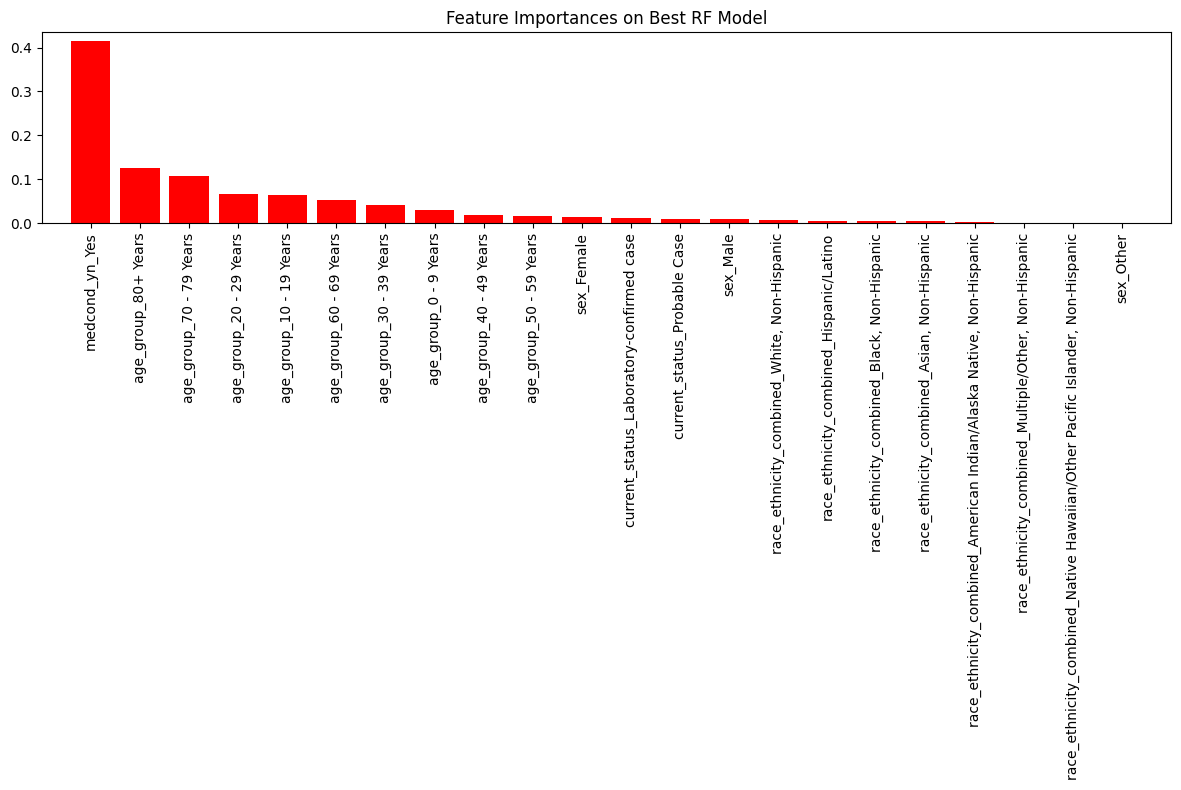

In [79]:
#Feature Importance Plot
importances = best_rf_model.feature_importances_
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(12, 8))
plt.title("Feature Importances on Best RF Model")
plt.bar(range(len(importances)), importances[indices], color="r", align="center")
plt.xticks(range(len(importances)), [feature_names[i] for i in indices], rotation=90)
plt.xlim([-1, len(importances)])
plt.tight_layout()
plt.show()

In [80]:
start_time = time.time()
result = permutation_importance(
    best_rf_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=2
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 12.528 seconds


<ipython-input-81-36e0b373a1f7>:5: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations.
  fig.tight_layout()


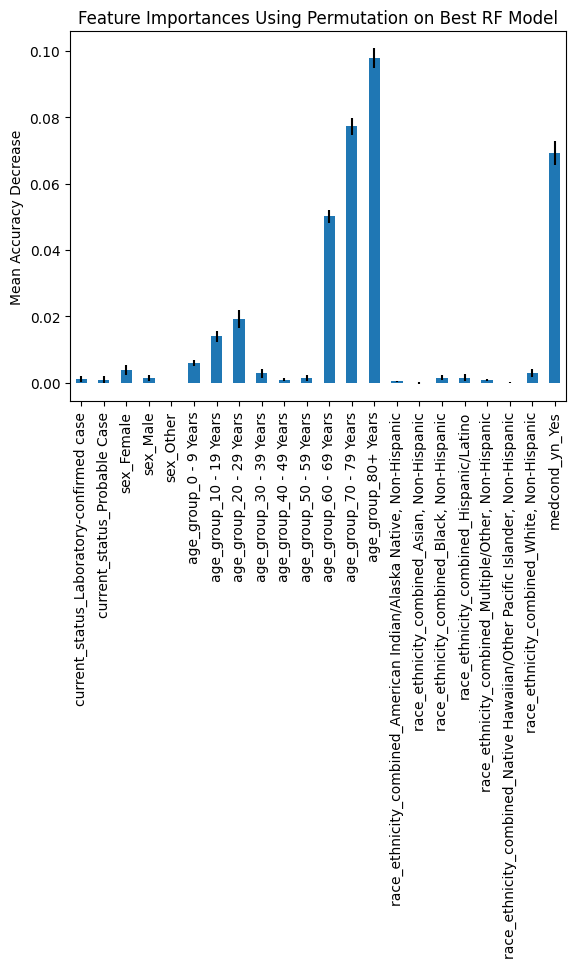

In [81]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature Importances Using Permutation on Best RF Model")
ax.set_ylabel("Mean Accuracy Decrease")
fig.tight_layout()
plt.show()

In [82]:
explainer = shap.TreeExplainer(best_rf_model)

X_sample = shap.sample(X_train, 10000)
shap_values_sample = explainer.shap_values(X_sample)

#Check shapes
print(f"SHAP values shape: {np.array(shap_values_sample).shape}")
print(f"X_train shape: {X_train.shape}")

shap_values_positive_class = shap_values_sample[:, :, 1]

SHAP values shape: (10000, 22, 2)
X_train shape: (46056, 22)


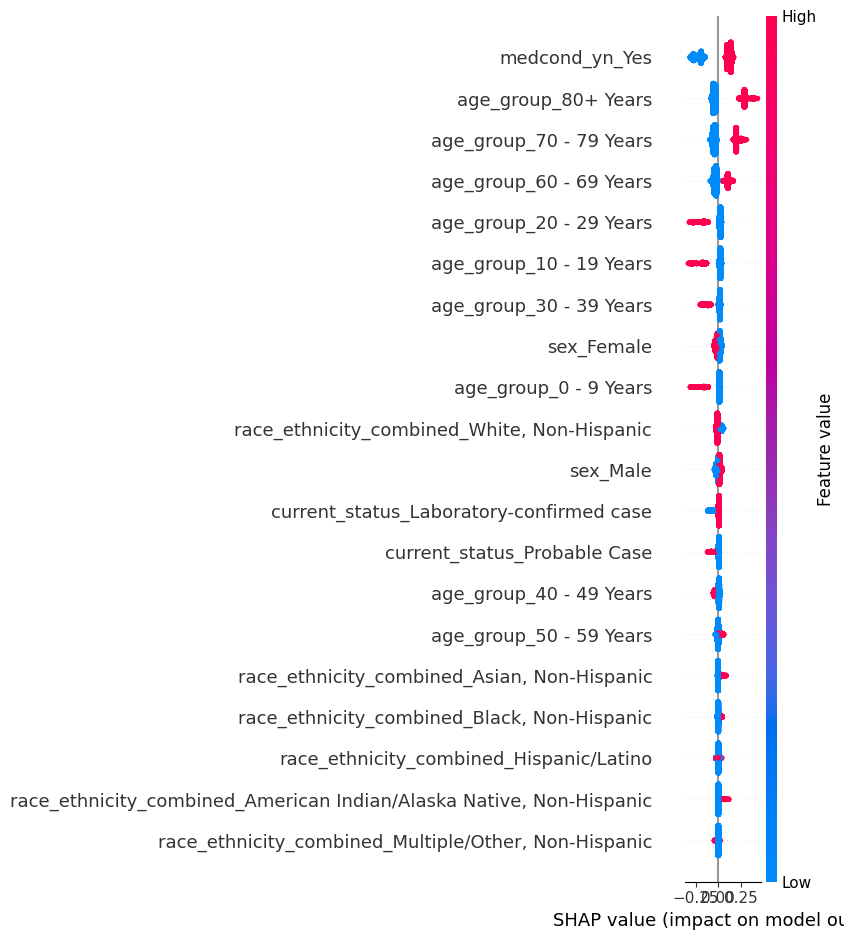

In [83]:
shap.summary_plot(shap_values_positive_class, X_sample, feature_names=feature_names, plot_type="dot")

Non-Death


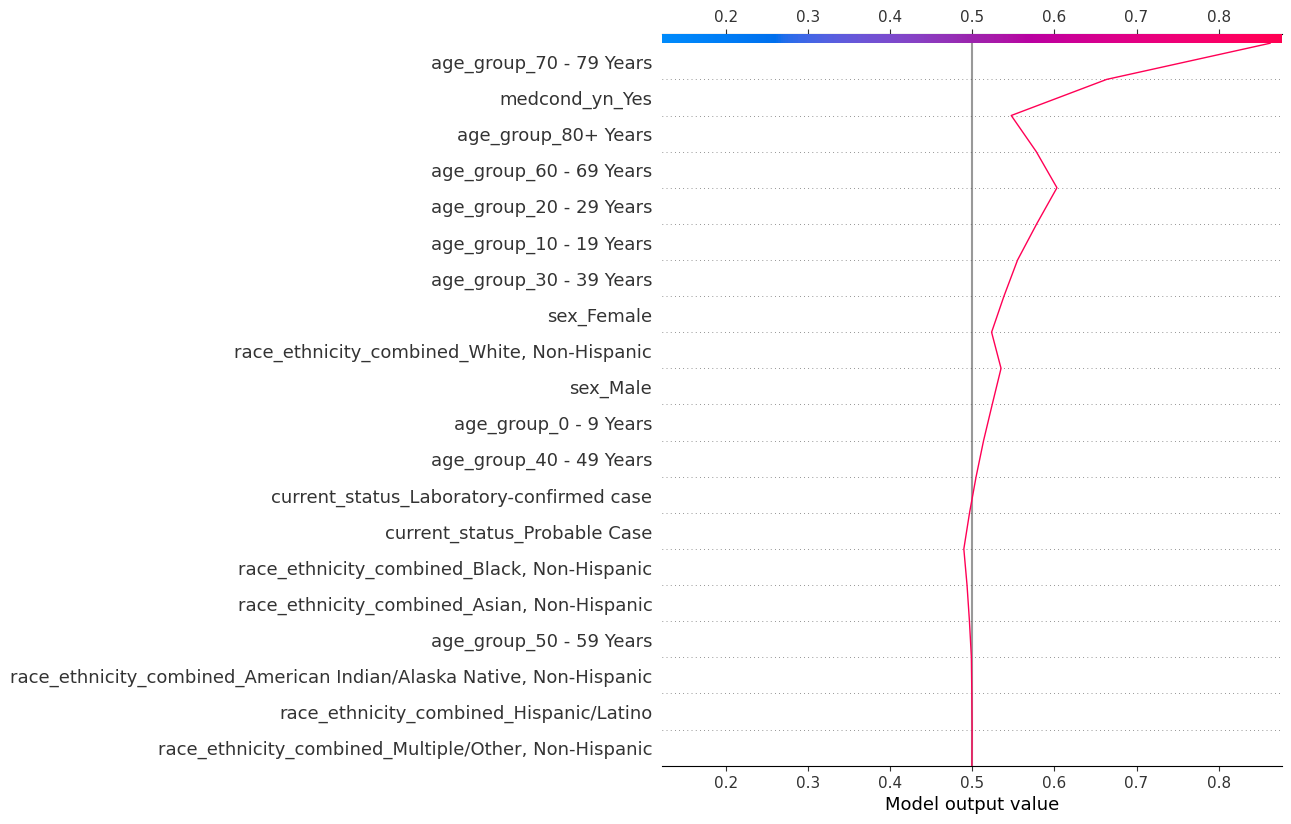

In [88]:
print("Death")
shap.decision_plot(explainer.expected_value[0], shap_values_positive_class[0], feature_names=feature_names)

Death


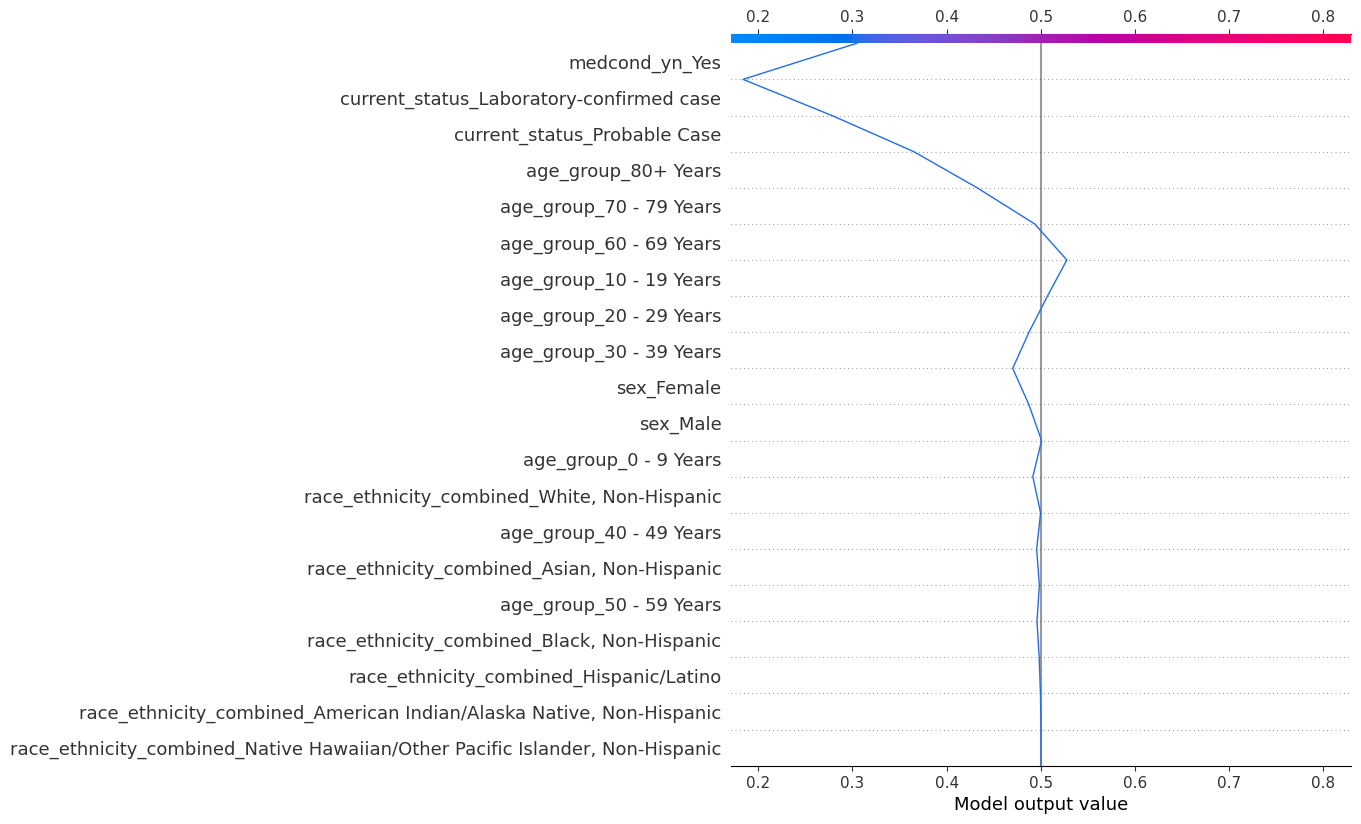

In [87]:
print("Non-Death")
shap.decision_plot(explainer.expected_value[1], shap_values_positive_class[1], feature_names)